[View in Colaboratory](https://colab.research.google.com/github/zeinsh/experementaldataprocessing/blob/master/FR/dropout0_3.ipynb)

# Face Recognition

## Base model + dropout=0.3

<table>
  <tr><td><B>Optimizer</B></td><td>Adam</td></tr>
  <tr><td><B>Loss function</B></td><td>sparse_categorical_crossentropy</td></tr>
  <tr><td><B>Quality Metric</B></td><td>Accuracy</td></tr>
</table>

<Br/>
<B>Neural Network Architecture:</B>

- input layer
  - Input size 150x150
- First Layer
  - Convolution Layer: 
    - number of filters = 32
    - Filter size = 3x3
    - activation: ReLU
    - dropout
  - Pooling layer
    - size = 2x2
- Second Layer
  - Convolution Layer: 
    - number of filters = 32
    - Filter size = 3x3
    - activation: ReLU
    - dropout
  - Pooling layer
    - size = 2x2
- Third Layer
  - Convolution Layer: 
    - number of filters = 64
    - Filter size = 3x3
    - activation: ReLU
    - dropout
  - Pooling layer
    - size = 2x2
- Dense Layer 1
  - number of neurons = 64
  - activation = ReLU
  - dropout
- output Layer  (Dense)
  - number of neurons = identities_count
  - activation = sigmoid

In [0]:
!pip install -q imutils

In [2]:
## Essentials
import numpy as np
import imutils
import argparse
import cv2
import os                                                                                                             
import random
from PIL import Image
import matplotlib.image as mpimg
from math import ceil
import matplotlib.pyplot as plt
# from skimage.feature import hog


## Keras
from keras.models import Model, load_model
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import ZeroPadding2D

## Analysis
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score

# Add-ons
# from tqdm import tqdm
# from keras_tqdm import TQDMNotebookCallback

## Path Delimiter depending on os
path_delimiter = os.sep

Using TensorFlow backend.


In [3]:
# download dataset
# dataset path: http://vision.seas.harvard.edu/pubfig83/pubfig83.v1.tgz
!wget http://vision.seas.harvard.edu/pubfig83/pubfig83.v1.tgz

--2018-05-10 11:52:29--  http://vision.seas.harvard.edu/pubfig83/pubfig83.v1.tgz
Resolving vision.seas.harvard.edu (vision.seas.harvard.edu)... 54.165.123.1
Connecting to vision.seas.harvard.edu (vision.seas.harvard.edu)|54.165.123.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38317991 (37M) [application/x-gzip]
Saving to: ‘pubfig83.v1.tgz’

pubfig83.v1.tgz     100%[===================>]  36.54M  25.6MB/s    in 1.4s    

2018-05-10 11:52:31 (25.6 MB/s) - ‘pubfig83.v1.tgz’ saved [38317991/38317991]



In [0]:
!tar -xzf pubfig83.v1.tgz

In [5]:
def list_files(dir_name):
    r = []
    for root, dirs, files in os.walk(dir_name):
        for name in files:
            r.append(os.path.join(root, name))
    return r

def dirs_count(dir_name):
    import os
    return len(next(os.walk(dir_name))[1])

DATASET_PATH = 'pubfig83'
image_paths=list_files(DATASET_PATH)
print(len(image_paths))

13838


In [0]:
def get_eye_center(eye_rect):
    x,y,w,h = eye_rect
    return int(x + w / 2), int(y + h / 2)

class FaceAligner:
    def __init__(self, desiredLeftEye=(0.35, 0.35),
        desiredFaceWidth=256, desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, gray, eyes_rects):

        # extract the left and right eye (x, y)-coordinates
        leftEyePts, rightEyePts = eyes_rects

        # compute the center of mass for each eye
        leftEyeCenter = get_eye_center(leftEyePts)
        rightEyeCenter = get_eye_center(rightEyePts)

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)

        # return the aligned face
        return output

In [7]:
!wget https://raw.githubusercontent.com/shantnu/FaceDetect/master/haarcascade_frontalface_default.xml
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml

--2018-05-10 11:52:37--  https://raw.githubusercontent.com/shantnu/FaceDetect/master/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.1s    

2018-05-10 11:52:37 (6.79 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]

--2018-05-10 11:52:38--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request 

In [0]:
# Initializing Face Detector 
# Create the haar cascade
cascPath    = 'haarcascade_frontalface_default.xml'
cascEyePath = 'haarcascade_eye.xml'
faceCascadeDetector = cv2.CascadeClassifier(cascPath)
eyeCascadeDetector  = cv2.CascadeClassifier(cascEyePath)

fa = FaceAligner(desiredFaceWidth=150)

def get_point_rect_respective_pos(point, rect):
    rect_x, rect_y, rect_width, rect_height = rect
    point_x, point_y = point
    return [(point_x - rect_x) / rect_width, (point_y - rect_y) / rect_height]
    

def prepare_eyes_rects(eyes, face_rect):
    '''
    Right eye first
    Check the X-coordinate
    Leave only the leftmost and the rightmost rects
    Use heuristic for simplicity
    '''
    left_eye_min_x_pos = 0
    left_eye_max_x_pos = 0.4
    left_eye_min_y_pos = 0.3
    left_eye_max_y_pos = 0.5
    
    right_eye_min_x_pos = 0.6
    right_eye_max_x_pos = 1.0
    right_eye_min_y_pos = 0.3
    right_eye_max_y_pos = 0.5
    
    left_eye = right_eye = None
    for eye in eyes:
        eye_center = get_eye_center(eye)
        respective_pos = get_point_rect_respective_pos(eye_center, face_rect)
        if (left_eye is None or left_eye[0] > eye[0]) \
            and left_eye_min_x_pos <= respective_pos[0] <= left_eye_max_x_pos \
            and left_eye_min_y_pos <= respective_pos[1] <= left_eye_max_y_pos:
            left_eye = eye
        if (right_eye is None or right_eye[0] < eye[0]) \
            and right_eye_min_x_pos <= respective_pos[0] <= right_eye_max_x_pos \
            and right_eye_min_y_pos <= respective_pos[1] <= right_eye_max_y_pos:
            right_eye = eye
    
    if right_eye is None or left_eye is None:
        return None
    return [right_eye, left_eye]

def faceAlign(image):
    image = imutils.resize(image, width=150)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    rects = faceCascadeDetector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    eyes = eyeCascadeDetector.detectMultiScale(gray, minNeighbors=1, minSize=(10, 10))
    
    if len(eyes) < 2 or len(rects) != 1:
        return None
    
    face_rect = rects[0]
    eyes = prepare_eyes_rects(eyes, face_rect)
    if eyes is None:
        return None
    
    faceAligned = fa.align(image, gray, eyes)
    
    return faceAligned

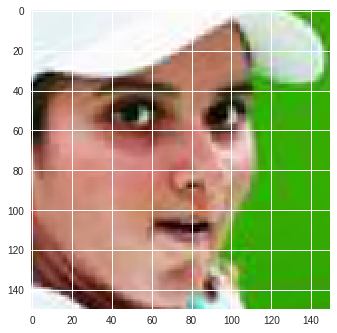

In [9]:
sample_image_path = image_paths[0]
sample_image = mpimg.imread(sample_image_path)
sample_image = imutils.resize(sample_image, width=150)

faceAligned = faceAlign(sample_image)

## Sample for Feature Exploration Later
if faceAligned is not None:
    plt.imshow(faceAligned)


In [10]:
## Label Encoder for string Labels

# Finding unique labels
all_labels = [imag.split(path_delimiter)[-2] for imag in image_paths];

## Encoding them
le = preprocessing.LabelEncoder()
le.fit(all_labels)
labels_enc = le.transform(all_labels)

unique_labels = list(le.classes_)
print('Labels: ')
[print(int(le.transform([label])),label) for label in unique_labels];

Labels: 
0 Adam Sandler
1 Alec Baldwin
2 Angelina Jolie
3 Anna Kournikova
4 Ashton Kutcher
5 Avril Lavigne
6 Barack Obama
7 Ben Affleck
8 Beyonce Knowles
9 Brad Pitt
10 Cameron Diaz
11 Cate Blanchett
12 Charlize Theron
13 Christina Ricci
14 Claudia Schiffer
15 Clive Owen
16 Colin Farrell
17 Colin Powell
18 Cristiano Ronaldo
19 Daniel Craig
20 Daniel Radcliffe
21 David Beckham
22 David Duchovny
23 Denise Richards
24 Drew Barrymore
25 Dustin Hoffman
26 Ehud Olmert
27 Eva Mendes
28 Faith Hill
29 George Clooney
30 Gordon Brown
31 Gwyneth Paltrow
32 Halle Berry
33 Harrison Ford
34 Hugh Jackman
35 Hugh Laurie
36 Jack Nicholson
37 Jennifer Aniston
38 Jennifer Lopez
39 Jennifer Love Hewitt
40 Jessica Alba
41 Jessica Simpson
42 Joaquin Phoenix
43 John Travolta
44 Julia Roberts
45 Julia Stiles
46 Kate Moss
47 Kate Winslet
48 Katherine Heigl
49 Keira Knightley
50 Kiefer Sutherland
51 Leonardo DiCaprio
52 Lindsay Lohan
53 Mariah Carey
54 Martha Stewart
55 Matt Damon
56 Meg Ryan
57 Meryl Streep
58 

In [0]:
def augment_brightness_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .6+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

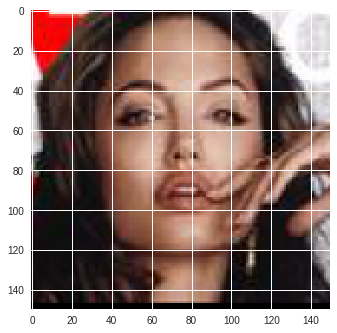

In [12]:
# for data_cropped folder

def read_images(image_paths):
    images = [];
    labels = [];
    for img_path in image_paths:
        try:
          image = faceAlign(mpimg.imread(img_path));
        except Exception as e:
            continue
        if image is not None and np.shape(np.shape(image)) == (3, ):
            images.append(image)
            labels.append(img_path.split(path_delimiter)[1])
    return images,labels


sample_length = 15
image_paths=list_files(DATASET_PATH)
sample_dt=random.sample(image_paths,int(sample_length))
images,labels=read_images(sample_dt)

## Test image reading
image = images[0]
plt.imshow(image);

In [0]:
## Send image_paths of the data_cropped folder
ALIGNED_DATASET_PATH = 'pubfig_aligned'
def save_align_imgs(image_paths):
    for img_path in image_paths:
        try:
            image = faceAlign(mpimg.imread(img_path));
        except:
            continue
        folder = img_path.split(path_delimiter)[-2]
        filename = img_path.split(path_delimiter)[-1]

        if image is not None and np.shape(np.shape(image)) == (3, ):
            if not os.path.exists(ALIGNED_DATASET_PATH+'/'+folder): os.makedirs(ALIGNED_DATASET_PATH+'/'+folder)
            save_image_path = "{}/{}/{}.jpg".format(ALIGNED_DATASET_PATH, folder,filename)
            cv2.imwrite(save_image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [0]:
if not os.path.exists(ALIGNED_DATASET_PATH):
    save_align_imgs(image_paths)

In [0]:
# read_images fnc for 'data_aligned' images folder

def read_images_align(image_paths , mod_algo = 0):
    images = [];
    labels = [];
    for img_path in image_paths:
        image = mpimg.imread(img_path)
        images.append(image)
        labels.append(img_path.split(path_delimiter)[1])
    
    if mod_algo:
        ## Modified algorithm to augment brightness. Base Model Does not use modified Algorithm
        sz_img = np.array(images).shape[0]
        ind = (np.random.choice(sz_img, int(sz_img/3), replace=False)).astype(int)
        for n in ind:
            images[n] = augment_brightness_images(images[n])
    
    return images,labels

Shape of the image array:  (50, 1, 150, 150)
Shape of the image:  (1, 150, 150)
Shape of image after reshaping:  (150, 150)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

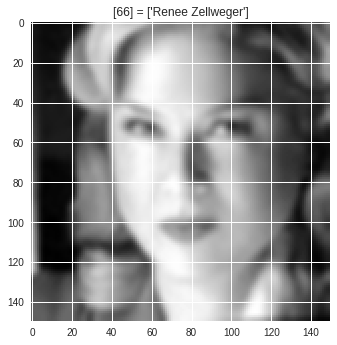

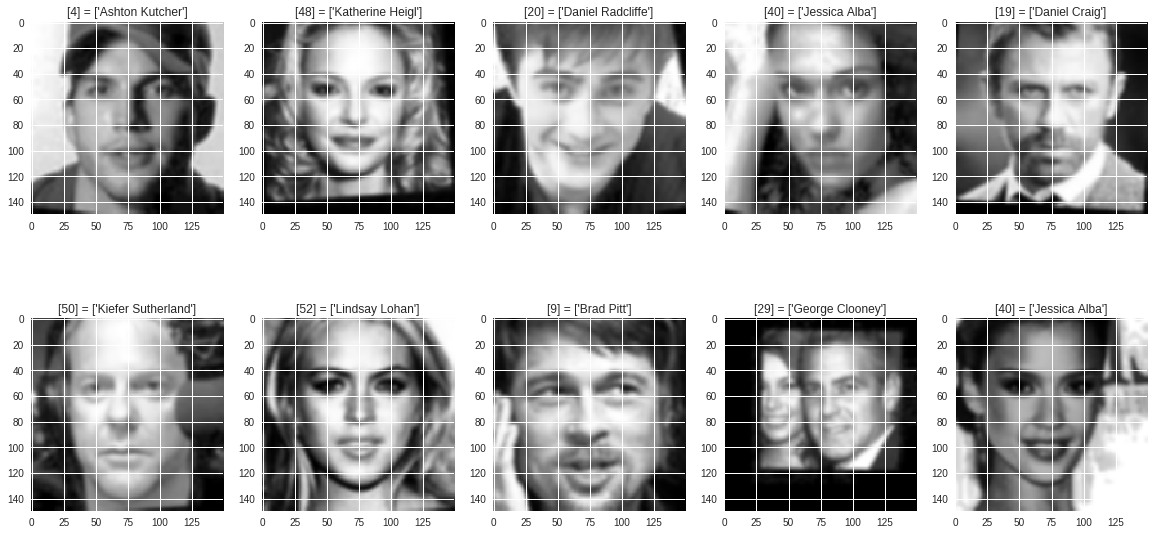

In [28]:
## If setting read_aligned to 0, change the folder

from sklearn.model_selection import train_test_split

def data_gen(batch_size=30, valid_part = 0.2, read_aligned = 1, folder = ALIGNED_DATASET_PATH):
  image_paths = list_files(folder)
  
  train_images, valid_images = train_test_split(image_paths, test_size = valid_part)
  def get_func(image_paths):
    def func():
      while True:

          ## Define the ouput image size desired
          output_img_sz = 150

          ## Take random set of data of size ('batch_size' + 10) to avoid images 
          ## that are unable to load or have no face in it
          sample_dt=random.sample(image_paths,int(batch_size)+10)

          if read_aligned == 1:
              images,labels = read_images_align(sample_dt,1)
          else:
              images,labels = read_images(sample_dt)

          ## Converting them to numpy arrays
          images=np.asarray(images)
          labels=np.asarray(labels)

          flipped_img=[];
          blur_grays = [];

          for image in images:
              ## Converting to grayscale and Equalizing Histogram
              gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
              gray = cv2.equalizeHist(gray)

              ## Resizing the images to output size
              gray = cv2.resize(gray, (output_img_sz, output_img_sz)) 

              ## Adding Gaussian Blur to distort the images a bit
              kernel_size = 7 # Must be an odd number (3, 5, 7...)
              blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
              blur_grays.append(blur_gray)

              ## Flipping the images
              flipped_img.append(np.fliplr(blur_gray))

          ## Appending the Flipped images to 'blur_gray' image array 
          blur_grays = np.append(blur_grays , flipped_img, axis = 0)
          labels = np.append(labels, labels , axis=0)

          ## Choosing a random set of images
          ind = np.random.choice(blur_grays.shape[0], batch_size, replace=False)
          blur_grays=blur_grays[ind,:,:]
          labels=le.transform(labels[ind])

          ## Converting the colorscale to float32
          blur_grays = blur_grays.astype('float32')
          ## Normalizing
          blur_grays /= 255.

          ## Reshaping the image and label arrays and registering as output
          X = np.reshape(blur_grays, [-1,1,output_img_sz,output_img_sz])
          y = np.reshape(labels, [ -1,1])        

          yield X,y
    return func()
  
  return get_func(train_images), get_func(valid_images)
   


### Testing the data generator function

sample_images,sample_labels = next(data_gen(50)[0])
print('Shape of the image array: ', np.shape(sample_images))

## Selecting random image
sample_choice = random.randint(0,9)
sample_img = sample_images[sample_choice]
print('Shape of the image: ', np.shape(sample_img))

## Reshaping to plot the image correctly
sample_img = np.reshape(sample_img,[np.shape(sample_img)[2],np.shape(sample_img)[2]])
print('Shape of image after reshaping: ', np.shape(sample_img))
plt.figure(1)
plt.imshow(sample_img, cmap = 'gray')
plt.title(str(sample_labels[sample_choice])+' = '+str(le.inverse_transform(sample_labels[sample_choice])))


ind = np.random.choice(sample_images.shape[0], 10, replace=False)


fig = plt.figure(2,figsize=[20,10])


for ix, idx in enumerate(ind):
    plt.subplot(2,5,ix+1)
    sample_img = sample_images[idx]
    sample_img = np.reshape(sample_img,[np.shape(sample_img)[2],np.shape(sample_img)[2]])
    plt.imshow(sample_img, cmap = 'gray')
    plt.title(str(sample_labels[idx])+' = '+str(le.inverse_transform(sample_labels[idx])))

In [33]:
## Initial Training -  CNN Base Version 1
dropout_prob=0.3
l2_norm=0.00
input_shape=(1, sample_img.shape[0],sample_img.shape[1])

identities_count = dirs_count(ALIGNED_DATASET_PATH)


input_layer = Input(shape=input_shape)
# <PASTE MODEL CODE HERE>
X=Conv2D(filters=32,kernel_size=(3,3),activation='relu',data_format="channels_first"\
         ,kernel_regularizer=regularizers.l2(l2_norm))(input_layer)
X = BatchNormalization(axis = 1)(X)
X=MaxPooling2D(pool_size=(2,2), data_format="channels_first")(X)
X=Dropout(dropout_prob)(X)

X=Conv2D(filters = 32, kernel_size=(3,3), activation='relu',  data_format="channels_first"\
        ,kernel_regularizer=regularizers.l2(l2_norm))(X)
X = BatchNormalization(axis = 1)(X)
X=MaxPooling2D(pool_size=(2,2), data_format="channels_first")(X)
X=Dropout(dropout_prob)(X)

X=Conv2D(filters = 64, kernel_size=(3,3), activation='relu',  data_format="channels_first"\
        ,kernel_regularizer=regularizers.l2(l2_norm))(X)
X = BatchNormalization(axis = 1)(X)
X=MaxPooling2D(pool_size=(2,2), data_format="channels_first")(X)
X=Dropout(dropout_prob)(X)

X=Flatten()(X)
X=Dense(64, activation='relu')(X)
X=Dropout(dropout_prob)(X)
model_out = Dense(identities_count, activation="sigmoid")(X)

model = Model(inputs=[input_layer], outputs=model_out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


## Initial Training
batch_size=32
epochs=4
samp_per_epoch=1000

steps_per_epoch = batch_size * ceil(samp_per_epoch/batch_size)

gen_train, gen_valid = data_gen(batch_size)

model.summary()
#model_hist = model.fit_generator(gen_train, steps_per_epoch = steps_per_epoch, nb_epoch=epochs,
#                         validation_data=gen_valid, nb_val_samples=25, max_q_size=25, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 150, 150)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 148, 148)      320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 148, 148)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 74, 74)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 74, 74)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 72, 72)        9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 72, 72)        128       
__________

In [34]:
## Final Training
batch_size=32
epochs=50
samp_per_epoch=2000

samp_per_epoch = batch_size * ceil(samp_per_epoch/batch_size)

model_hist = model.fit_generator(gen_train, steps_per_epoch = steps_per_epoch,nb_epoch=epochs,
                         validation_data=gen_valid,nb_val_samples=25, max_q_size=25, verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1024, validation_data=<generator..., verbose=1, epochs=50, validation_steps=25, max_queue_size=25)`
  


Epoch 1/50
1024/1024 [==============================] - 85s 83ms/step - loss: 4.4111 - acc: 0.0258 - val_loss: 5.1508 - val_acc: 0.0225
Epoch 2/50
  18/1024 [..............................] - ETA: 1:12 - loss: 4.3765 - acc: 0.0278

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3676 - acc: 0.0263 - val_loss: 4.4864 - val_acc: 0.0225
Epoch 3/50
  72/1024 [=>............................] - ETA: 1:07 - loss: 4.3477 - acc: 0.0230

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3470 - acc: 0.0267 - val_loss: 4.4062 - val_acc: 0.0125
Epoch 4/50
  92/1024 [=>............................] - ETA: 1:05 - loss: 4.3465 - acc: 0.0245

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3416 - acc: 0.0263 - val_loss: 4.3360 - val_acc: 0.0175
Epoch 5/50
  99/1024 [=>............................] - ETA: 1:04 - loss: 4.3339 - acc: 0.0243

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3345 - acc: 0.0257 - val_loss: 4.3412 - val_acc: 0.0163
Epoch 6/50
 104/1024 [==>...........................] - ETA: 1:04 - loss: 4.3243 - acc: 0.0300

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3286 - acc: 0.0281 - val_loss: 4.3603 - val_acc: 0.0225
Epoch 7/50
  98/1024 [=>............................] - ETA: 1:04 - loss: 4.3495 - acc: 0.0249

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3310 - acc: 0.0247 - val_loss: 4.3414 - val_acc: 0.0312
Epoch 8/50
 100/1024 [=>............................] - ETA: 1:04 - loss: 4.3371 - acc: 0.0241

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3295 - acc: 0.0249 - val_loss: 4.3619 - val_acc: 0.0238
Epoch 9/50
 103/1024 [==>...........................] - ETA: 1:04 - loss: 4.3279 - acc: 0.0243

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3307 - acc: 0.0263 - val_loss: 4.3233 - val_acc: 0.0238
Epoch 10/50
 106/1024 [==>...........................]

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3213 - acc: 0.0281 - val_loss: 4.3499 - val_acc: 0.0213
Epoch 11/50
 107/1024 [==>...........................] - ETA: 1:03 - loss: 4.3257 - acc: 0.0289

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3237 - acc: 0.0260 - val_loss: 4.3322 - val_acc: 0.0187
Epoch 12/50
 106/1024 [==>...........................] - ETA: 1:03 - loss: 4.3184 - acc: 0.0236

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3208 - acc: 0.0274 - val_loss: 4.3531 - val_acc: 0.0187
Epoch 13/50
 106/1024 [==>...........................] - ETA: 1:04 - loss: 4.3269 - acc: 0.0295

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3269 - acc: 0.0277 - val_loss: 4.3315 - val_acc: 0.0350
Epoch 14/50
 108/1024 [==>...........................] - ETA: 1:04 - loss: 4.3189 - acc: 0.0234

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3229 - acc: 0.0280 - val_loss: 4.3368 - val_acc: 0.0275
Epoch 15/50
 107/1024 [==>...........................] - ETA: 1:03 - loss: 4.3244 - acc: 0.0254

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3248 - acc: 0.0268 - val_loss: 4.3243 - val_acc: 0.0163
Epoch 16/50
 106/1024 [==>...........................] - ETA: 1:04 - loss: 4.3299 - acc: 0.0268

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3253 - acc: 0.0274 - val_loss: 4.3112 - val_acc: 0.0262
Epoch 17/50
 108/1024 [==>...........................] - ETA: 1:04 - loss: 4.3264 - acc: 0.0243

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3285 - acc: 0.0251 - val_loss: 4.3125 - val_acc: 0.0350
Epoch 18/50
 106/1024 [==>...........................] - ETA: 1:03 - loss: 4.3309 - acc: 0.0256

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3279 - acc: 0.0278 - val_loss: 4.3579 - val_acc: 0.0238
Epoch 19/50
  98/1024 [=>............................] - ETA: 1:04 - loss: 4.3310 - acc: 0.0284

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3288 - acc: 0.0263 - val_loss: 4.3206 - val_acc: 0.0262
Epoch 20/50
 103/1024 [==>...........................] - ETA: 1:04 - loss: 4.3240 - acc: 0.0228

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3231 - acc: 0.0262 - val_loss: 4.3127 - val_acc: 0.0250
Epoch 21/50
 106/1024 [==>...........................] - ETA: 1:04 - loss: 4.3308 - acc: 0.0203

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3230 - acc: 0.0266 - val_loss: 4.3420 - val_acc: 0.0275
Epoch 22/50
 102/1024 [=>............................] - ETA: 1:04 - loss: 4.3337 - acc: 0.0334

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3248 - acc: 0.0270 - val_loss: 4.3161 - val_acc: 0.0238
Epoch 23/50
 105/1024 [==>...........................] - ETA: 1:04 - loss: 4.3296 - acc: 0.0256

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3218 - acc: 0.0274 - val_loss: 4.3494 - val_acc: 0.0325
Epoch 24/50
 107/1024 [==>...........................] - ETA: 1:03 - loss: 4.3354 - acc: 0.0254

1024/1024 [==============================] - 83s 82ms/step - loss: 4.3276 - acc: 0.0276 - val_loss: 4.3321 - val_acc: 0.0288
Epoch 25/50
 107/1024 [==>...........................] - ETA: 1:03 - loss: 4.3249 - acc: 0.0275

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3250 - acc: 0.0272 - val_loss: 4.3451 - val_acc: 0.0275
Epoch 26/50
 105/1024 [==>...........................] - ETA: 1:04 - loss: 4.3269 - acc: 0.0238

1024/1024 [==============================] - 83s 82ms/step - loss: 4.3273 - acc: 0.0257 - val_loss: 4.3181 - val_acc: 0.0425
Epoch 27/50
 109/1024 [==>...........................] - ETA: 1:04 - loss: 4.3273 - acc: 0.0295

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3246 - acc: 0.0274 - val_loss: 4.3247 - val_acc: 0.0300
Epoch 28/50
 105/1024 [==>...........................] - ETA: 1:03 - loss: 4.3201 - acc: 0.0253

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3233 - acc: 0.0275 - val_loss: 4.3376 - val_acc: 0.0275
Epoch 29/50
 105/1024 [==>...........................] - ETA: 1:02 - loss: 4.3206 - acc: 0.0262

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3266 - acc: 0.0284 - val_loss: 4.3318 - val_acc: 0.0275
Epoch 30/50
 107/1024 [==>...........................] - ETA: 1:04 - loss: 4.3301 - acc: 0.0263

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3221 - acc: 0.0256 - val_loss: 4.3514 - val_acc: 0.0225
Epoch 31/50
 103/1024 [==>...........................] - ETA: 1:04 - loss: 4.3414 - acc: 0.0237

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3267 - acc: 0.0274 - val_loss: 4.3221 - val_acc: 0.0362
Epoch 32/50
 100/1024 [=>............................] - ETA: 1:05 - loss: 4.3177 - acc: 0.0322

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3241 - acc: 0.0285 - val_loss: 4.3293 - val_acc: 0.0225
Epoch 33/50
 100/1024 [=>............................] - ETA: 1:04 - loss: 4.3151 - acc: 0.0266

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3276 - acc: 0.0275 - val_loss: 4.3473 - val_acc: 0.0300
Epoch 34/50
 103/1024 [==>...........................] - ETA: 1:04 - loss: 4.3217 - acc: 0.0300

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3292 - acc: 0.0277 - val_loss: 4.3332 - val_acc: 0.0200
Epoch 35/50
 107/1024 [==>...........................] - ETA: 1:03 - loss: 4.3423 - acc: 0.0242

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3242 - acc: 0.0266 - val_loss: 4.3436 - val_acc: 0.0275
Epoch 36/50
 110/1024 [==>...........................] - ETA: 1:03 - loss: 4.3252 - acc: 0.0261

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3247 - acc: 0.0251 - val_loss: 4.3297 - val_acc: 0.0200
Epoch 37/50
 107/1024 [==>...........................] - ETA: 1:02 - loss: 4.3366 - acc: 0.0239

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3250 - acc: 0.0263 - val_loss: 4.3379 - val_acc: 0.0088
Epoch 38/50
 105/1024 [==>...........................] - ETA: 1:03 - loss: 4.3141 - acc: 0.0301

1024/1024 [==============================] - 83s 82ms/step - loss: 4.3217 - acc: 0.0285 - val_loss: 4.3646 - val_acc: 0.0250
Epoch 39/50
 102/1024 [=>............................] - ETA: 1:02 - loss: 4.3128 - acc: 0.0303

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3240 - acc: 0.0279 - val_loss: 4.3182 - val_acc: 0.0387
Epoch 40/50
 108/1024 [==>...........................] - ETA: 1:04 - loss: 4.3148 - acc: 0.0315

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3220 - acc: 0.0279 - val_loss: 4.3208 - val_acc: 0.0125
Epoch 41/50
 105/1024 [==>...........................]

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3232 - acc: 0.0274 - val_loss: 4.3422 - val_acc: 0.0250
Epoch 42/50
 108/1024 [==>...........................] - ETA: 1:02 - loss: 4.3339 - acc: 0.0231

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3265 - acc: 0.0254 - val_loss: 4.3299 - val_acc: 0.0312
Epoch 43/50
 106/1024 [==>...........................] - ETA: 1:04 - loss: 4.3104 - acc: 0.0295

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3245 - acc: 0.0279 - val_loss: 4.3222 - val_acc: 0.0300
Epoch 44/50
 110/1024 [==>...........................] - ETA: 1:04 - loss: 4.3086 - acc: 0.0278

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3259 - acc: 0.0262 - val_loss: 4.3467 - val_acc: 0.0238
Epoch 45/50
 108/1024 [==>...........................] - ETA: 1:03 - loss: 4.3225 - acc: 0.0266

1024/1024 [==============================] - 83s 81ms/step - loss: 4.3267 - acc: 0.0263 - val_loss: 4.3555 - val_acc: 0.0262
Epoch 46/50
 104/1024 [==>...........................] - ETA: 1:03 - loss: 4.3200 - acc: 0.0228

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3209 - acc: 0.0277 - val_loss: 4.3408 - val_acc: 0.0400
Epoch 47/50
  94/1024 [=>............................] - ETA: 1:04 - loss: 4.3234 - acc: 0.0239

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3281 - acc: 0.0255 - val_loss: 4.3294 - val_acc: 0.0238
Epoch 48/50


1024/1024 [==============================] - 84s 82ms/step - loss: 4.3256 - acc: 0.0262 - val_loss: 4.3397 - val_acc: 0.0250
Epoch 49/50
 104/1024 [==>...........................] - ETA: 1:03 - loss: 4.3269 - acc: 0.0346

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3267 - acc: 0.0262 - val_loss: 4.3637 - val_acc: 0.0225
Epoch 50/50
 103/1024 [==>...........................] - ETA: 1:02 - loss: 4.3361 - acc: 0.0258

1024/1024 [==============================] - 84s 82ms/step - loss: 4.3262 - acc: 0.0288 - val_loss: 4.3323 - val_acc: 0.0288


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


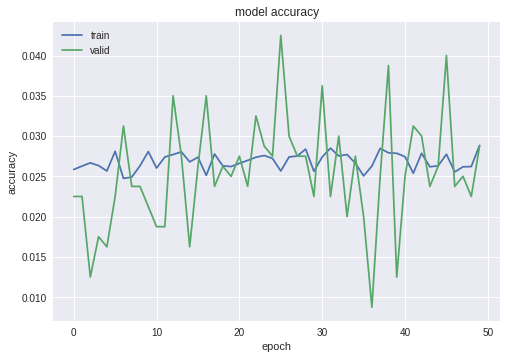

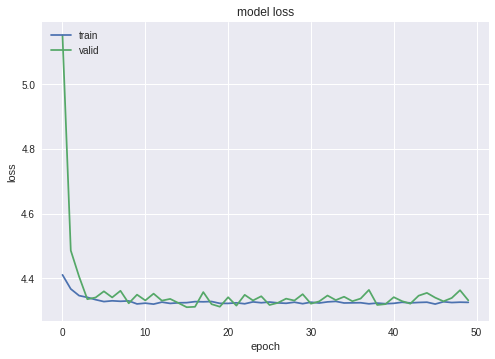

In [35]:
# list all data in history
print(model_hist.history.keys())
# summarize history for accuracy
plt.plot(model_hist.history['acc'])
plt.plot(model_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()